#### Aerosandbox Simulation Analysis example

This example shows the basic CITROS data analysis functions and based on the simulations made with Aerosandbox python library.



First of all, we should import all neccesary libs:

In [ ]:
import numpy as np

import matplotlib.pyplot as plt

from citros_data_analysis import data_access as da

from prettytable import PrettyTable, ALL

import json

from platform import python_version

from citros import CitrosDB



Now we can connect to the simulation database:

In [ ]:
citros = CitrosDB(simulation='simulation_aerosandbox_cessna', batch='aerosandbox_cessna')

citros.info().print()


{
 'size': '261 kB',
 'sid_count': 10,
 'sid_list': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 'topic_count': 2,
 'topic_list': ['/aerosandbox_cessna/state', '/config'],
 'message_count': 1010
}


As you can see in the output above, we've got some information about our simulation run (batch):
1. Size of data
2. Sid information. In case we have more then one sid - this will be shown here.
3. Number and a list of topics. First three topics are build-in system topics, and the last one is our simulation results. 

Let's go further:

In [80]:
citros.sid([0]).info().print()

{
 'size': '26 kB',
 'sid_count': 1,
 'sid_list': [0],
 'topic_count': 2,
 'topic_list': ['/aerosandbox_cessna/state', '/config'],
 'message_count': 101,
 'sids': {
   0: {
     'topics': {
       '/aerosandbox_cessna/state': {
         'message_count': 100,
         'start_time': 1695800207654867299,
         'end_time': 1695800217554762155,
         'duration': 9899894856,
         'frequency': 10.101
       },
       '/config': {
         'message_count': 1,
         'start_time': 0,
         'end_time': 0,
         'duration': 0,
         'frequency': 0
       }
     }
   }
 }
}


This shows us more detailed statistics about topics: time stamps, durations, number of messages etc.
Let's inspect our data topic:

In [91]:
citros.topic('/aerosandbox_cessna/state').sid(0).info().print()

{
 'size': '26 kB',
 'sid_count': 1,
 'sid_list': [0],
 'topic_count': 1,
 'topic_list': ['/aerosandbox_cessna/state'],
 'message_count': 100,
 'sids': {
   0: {
     'topics': {
       '/aerosandbox_cessna/state': {
         'message_count': 100,
         'start_time': 1695800207654867299,
         'end_time': 1695800217554762155,
         'duration': 9899894856,
         'frequency': 10.101
       }
     }
   }
 },
 'topics': {
   '/aerosandbox_cessna/state': {
     'type': 'std_msgs/msg/Float64MultiArray',
     'data_structure': {
       'data': {
         'data': 'list',
         '__msgtype__': 'str'
       }
     },
     'message_count': 100
   }
 }
}


Here we can see that our data topic contains 99 messages, and each one's type is a Float64MultiArray. 
Let's print all raw data:

In [82]:
print(citros.topic('/aerosandbox_cessna/state').data())

     sid  rid                 time                      topic  \
0      0    0  1695800207654867299  /aerosandbox_cessna/state   
1      0    1  1695800207754733750  /aerosandbox_cessna/state   
2      0    2  1695800207854725537  /aerosandbox_cessna/state   
3      0    3  1695800207954818078  /aerosandbox_cessna/state   
4      0    4  1695800208054803734  /aerosandbox_cessna/state   
..   ...  ...                  ...                        ...   
995    9   95  1695800490531216508  /aerosandbox_cessna/state   
996    9   96  1695800490631328332  /aerosandbox_cessna/state   
997    9   97  1695800490731231405  /aerosandbox_cessna/state   
998    9   98  1695800490831240812  /aerosandbox_cessna/state   
999    9   99  1695800490931263173  /aerosandbox_cessna/state   

                               type                data.__msgtype__  \
0    std_msgs/msg/Float64MultiArray  std_msgs/msg/Float64MultiArray   
1    std_msgs/msg/Float64MultiArray  std_msgs/msg/Float64MultiArray   
2    s

To get all json-data columns for a specific topic, function data() is used. It returns pandas DataFrame. To get a specific columns, pass their labels in a list as an argument:

In [83]:
print(citros.topic('/aerosandbox_cessna/state').data(['data.data[0]','data.data[1]'])[['data.data[0]', 'data.data[1]']])

      data.data[0]  data.data[1]
0         0.000000  1.000000e+03
1         8.121436  1.000113e+03
2        32.219632  1.001634e+03
3        71.163591  1.007109e+03
4       122.653412  1.018180e+03
..             ...           ...
995  186866.752329 -3.168922e-09
996  187070.026650 -8.477201e-09
997  187192.898283 -8.012343e-09
998  187254.307594  9.903690e-01
999  187272.747302 -9.838609e-09

[1000 rows x 2 columns]


Now we can create some plots. Let's plot coordinates along one of the axes (supposing messages come once a second): 

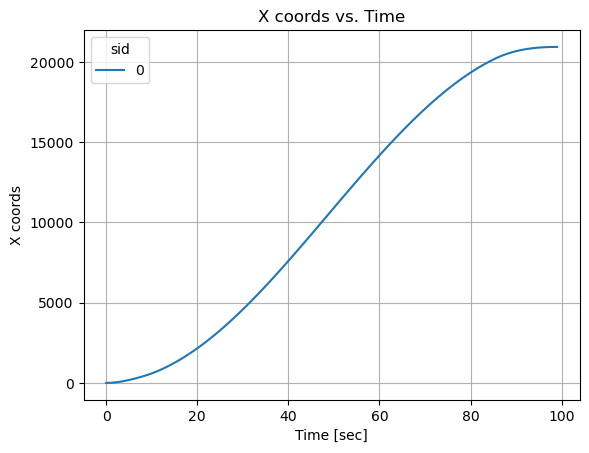

In [84]:
fig1, ax1 = plt.subplots()



citros.time_plot(ax1, 

                 topic_name = '/aerosandbox_cessna/state', 

                 var_name = 'data.data[0]', 

                 time_step = 1, 

                 sids = [0], 

                 y_label = 'X coords', title_text = 'X coords vs. Time')

Let's do some simple research. This simulation was started with custom parameter setup: one of the parameters (`h_0`) was defined with user-defined function, so we will see some difference between sid's data:

In [85]:
citros.info().print()

{
 'size': '261 kB',
 'sid_count': 10,
 'sid_list': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 'topic_count': 2,
 'topic_list': ['/aerosandbox_cessna/state', '/config'],
 'message_count': 1010
}


You can see here more than one sids - the simulation batch settings have been adjusted in such a way that each simulation corresponds to a parameter value from the range [1000..10000].

We will use this CITROS advantage to analyze how initial altitude affects on the gliding distance:

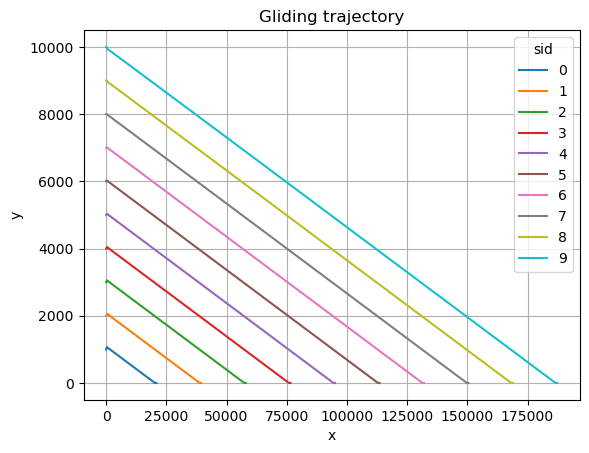

In [92]:
#create a figure to plot on

fig2, ax2 = plt.subplots()



citros.xy_plot(ax2, 

               topic_name = '/aerosandbox_cessna/state', 

               var_x_name = 'data.data[0]',

               var_y_name = 'data.data[1]',

               sids = [0,1,2,3,4,5,6,7,8,9], 

               x_label = 'x', y_label = 'y', title_text = 'Gliding trajectory')

This plot shows us that the trajectories have different gliding distance depending on initial altitude. You can see the small parts of plots where our Cessna trying to reach maximum altitude and optimal velocity.

Let's investigate how powerfull the influence is:

[20929.794694036755, 39491.251691719925, 58036.90124222829, 76559.32613701558, 95064.59109944498, 113550.89615581164, 132018.84541920273, 150464.43124314555, 168883.8522213893, 187272.74730226444]


Text(0.5, 1.0, 'Maximum gliding distance vs Initial altitude')

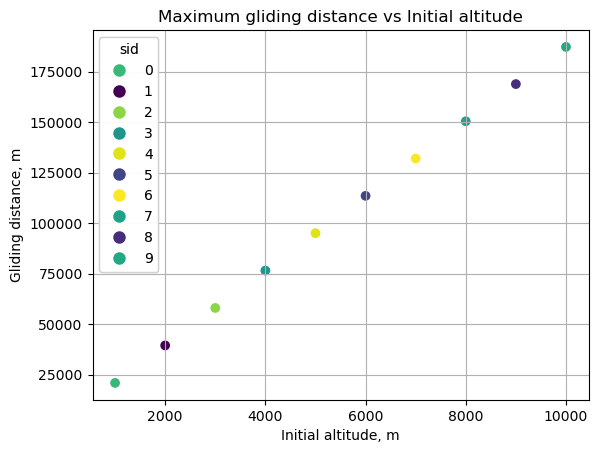

In [ ]:
# Defining the list of altitudes

h_0 = [i for i in range(1000,11000, 1000)]


# Setting Dataframe

df = citros.topic('/aerosandbox_cessna/state').set_order({'sid':'asc'}).data('data.data[0]')
sid_list = list(set(df['sid']))
data0_list = []
for s in sid_list:
    id_max = df[df['sid'] == s]['rid'].idxmax()
    data0_list.append(df['data.data[0]'].loc[id_max])

fig, ax = plt.subplots()

c = np.random.choice(50, 10, replace=False)
scatter = ax.scatter(h_0, data0_list,c=c)

# Create legend entries for each point
legend_labels = [str(i) for i in range(10)]

# Initialize a list to store legend handles
legend_handles = []

# Loop through the points and create legend entries with matching colors
for i, label in enumerate(legend_labels):
    color = scatter.to_rgba(c[i])  # Get the color of the corresponding point
    legend_handles.append(plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color, markersize=10))

# Add the legend with custom handles
legend1 = ax.legend(handles=legend_handles, loc="upper left", title="sid")
ax.add_artist(legend1)
ax.grid()
# plt.scatter(h_0, data0_list, cmap='plasma')
# # plt.plot(h_0, data0_list)
ax.set_ylabel('Gliding distance, m')
ax.set_xlabel('Initial altitude, m')
ax.set_title('Maximum gliding distance vs Initial altitude')
# plt.legend()


The gliding disctance increases from ~21000 m up to 187000 m while the initial altitude rises from 1000 to 10000. 